In [1]:
from os import path
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")


# Acquire Functions

- Used these to play around. Do not use these for final notebook. Use Kevin's!

In [2]:
def find_file(
    file_name='path/file.txt',
    cache=False,
    cache_age=None
    ):

    if cache==False:
        return None
    
    return path.exists(file_name)

In [3]:
def get_soup(
    url='https://github.com/search?o=desc&p=1&q=advent+of+code&s=stars&type=Repositories',
    headers={'User-Agent': 'Nothing suspicious'},
    file_name='soupfiles/gitsearch.txt',
    cache=False,
    cache_age=None,
    soup_slurper='*'
):
    # if we already have the data, read it locally
    file_found = find_file(file_name=file_name, cache=cache, cache_age=cache_age)
    if file_found:
        with open(file_name) as f:
            return BeautifulSoup(f.read())

    # otherwise go fetch the data
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text)
    slurps = soup.select(soup_slurper)

    # save it for next time
    with open(file_name, 'w') as f:
        f.write(str(slurps[0]))
        if len(slurps)>1:
            for slurp in slurps[1:]:
                f.write('\n' + str(slurp))
        
    with open(file_name) as f:    
        soup = BeautifulSoup(f.read())
#     pd.to_csv(slurps, header=None, index=False)

    return soup

In [4]:
def all_repositories():
    page = str(range(1,21))
    repo_list = []
    for p in page:
        repo_list.extend(get_links_from_page('https://github.com/search?o=desc&p='+p+'&q=advent+of+code&s=stars&type=Repositories'))
        return repo_list

In [5]:
def get_links_from_page(url):
    soup = get_soup(
    url=url,
    cache=True,
    soup_slurper='.repo-list-item a',
    file_name='soupfiles/gitsearch.txt'
)

# Prepare

## Functions

In [6]:
def normalize(string):
    # lower case the string
    string = string.lower()

    # replace new lines with an empty space
    string = re.sub(r'\n',' ',string)
    
    # normalize unicode characters
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # replace . with space
    string = re.sub(r'\.',' ',string)
    
    # replace / with space
    string = re.sub(r'/',' ',string)
    
    # replace c++ th c plus plus
    string = re.sub(r'c\+\+','cplusplus',string)

    # replace c+ with c plus
    string = re.sub(r'c\+','cplus ',string)

    # replace c# with c sharp
    string = re.sub(r'c#','csharp ',string)

    # replace f# with f sharp
    string = re.sub(r'f#','fsharp ',string)
    
    # replaces certain special characters with a space
    string = re.sub(r'[\[\](){}]',' ', string)
    
    # replace extra spaces with only one space
    string = re.sub(r'\s+',' ',string)

    # remove special characters with regex
    string = re.sub(r'[^a-z\s]','', string)
    
    return string

In [7]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

In [8]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

In [9]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

In [10]:
def remove_stopwords(tokenized_string, extra_words=['advent', 'of','code', 'aoc', 'day', 'solution', 'httpsgithub','githubhttpsimg','hpphttpsgithub','httpsadventofcode', 'adventofcode','commstksgadventofcodeblobmasterreflections', 'httpadventofcode','com', 'github', 'http', 'https','adventofcodehttps','master','blob','username', 'reponame'], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Read in json file containing repos and content

In [11]:
# read in content as json and save as dataframe
df = pd.read_json('datafiles/outdata.json')

In [12]:
type(df)

pandas.core.frame.DataFrame

In [13]:
# preview data
df.shape

(170, 6)

In [14]:
df.head(20)

,language,language_all,repo_full,author,repo,readme
0,Haskell,{'Haskell': 4468},BartoszMilewski/AdventOfCode18,BartoszMilewski,AdventOfCode18,# reponame\nsolutions to some of the advent of...
1,Haskell,{'Haskell': 139842},mstksg/advent-of-code-2019,mstksg,advent-of-code-2019,advent of code 2019\n=====================\n\n...
10,Kotlin,{'Kotlin': 53005},tginsberg/advent-2019-kotlin,tginsberg,advent-2019-kotlin,## advent of code 2019 solutions in kotlin\n\n...
100,Haskell,{'Haskell': 126402},mvaldesdeleon/aoc18,mvaldesdeleon,aoc18,"# advent of code 2018\n\nadvent of code 2018, ..."
101,Python,"{'Python': 156690, 'Rust': 104235, 'C++': 7148...",kodsnack/advent_of_code_2019,kodsnack,advent_of_code_2019,# advent of code 2019\ncontribute your solutio...
102,JavaScript,{'JavaScript': 37879},mariotacke/advent-of-code-2019,mariotacke,advent-of-code-2019,# advent of code 2019 - my solutions\n[![build...
103,JavaScript,{'JavaScript': 82820},markheath/advent-of-code-js,markheath,advent-of-code-js,# advent of code javascript solutions\n\nthis ...
104,Scala,"{'Scala': 187990, 'Shell': 798}",rolandtritsch/scala-aoc-2017,rolandtritsch,scala-aoc-2017,![build status](https://travis-ci.org/username...
105,Haskell,"{'Haskell': 109697, 'C++': 10145, 'Rust': 9909...",glguy/advent2018,glguy,advent2018,# advent of code 2018 haskell solutions\n\ni'm...
106,Python,{'Python': 189865},orez-/Advent-of-Code-2017,orez-,Advent-of-Code-2017,# advent of code 2017\n\nmy solutions for [adv...


### Create new columns which show readme content normalized, stemmed, and lemmatized

In [15]:
df = df.assign(normalized = df.readme.apply(normalize))
df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))

In [16]:
# preview results to decide which technique to use when reducing form of words (lemmatize vs stemming)
df

,language,language_all,repo_full,author,repo,readme,normalized,stemmed,lemmatized
0,Haskell,{'Haskell': 4468},BartoszMilewski/AdventOfCode18,BartoszMilewski,AdventOfCode18,# reponame\nsolutions to some of the advent of...,reponame solutions to some of the advent of c...,reponam solut to some of the advent of code pr...,reponame solution to some of the advent of cod...
1,Haskell,{'Haskell': 139842},mstksg/advent-of-code-2019,mstksg,advent-of-code-2019,advent of code 2019\n=====================\n\n...,advent of code this file generated by the b...,advent of code thi file gener by the build scr...,advent of code this file generated by the buil...
10,Kotlin,{'Kotlin': 53005},tginsberg/advent-2019-kotlin,tginsberg,advent-2019-kotlin,## advent of code 2019 solutions in kotlin\n\n...,advent of code solutions in kotlin license ...,advent of code solut in kotlin licens http img...,advent of code solution in kotlin license http...
100,Haskell,{'Haskell': 126402},mvaldesdeleon/aoc18,mvaldesdeleon,aoc18,"# advent of code 2018\n\nadvent of code 2018, ...",advent of code advent of code in haskell ht...,advent of code advent of code in haskel http a...,advent of code advent of code in haskell http ...
101,Python,"{'Python': 156690, 'Rust': 104235, 'C++': 7148...",kodsnack/advent_of_code_2019,kodsnack,advent_of_code_2019,# advent of code 2019\ncontribute your solutio...,advent of code contribute your solutions to ...,advent of code contribut your solut to advent ...,advent of code contribute your solution to adv...
102,JavaScript,{'JavaScript': 37879},mariotacke/advent-of-code-2019,mariotacke,advent-of-code-2019,# advent of code 2019 - my solutions\n[![build...,advent of code my solutions build status h...,advent of code my solut build statu http githu...,advent of code my solution build status http g...
103,JavaScript,{'JavaScript': 82820},markheath/advent-of-code-js,markheath,advent-of-code-js,# advent of code javascript solutions\n\nthis ...,advent of code javascript solutions this is a...,advent of code javascript solut thi is a repos...,advent of code javascript solution this is a r...
104,Scala,"{'Scala': 187990, 'Shell': 798}",rolandtritsch/scala-aoc-2017,rolandtritsch,scala-aoc-2017,![build status](https://travis-ci.org/username...,build status https travisci org username repo...,build statu http travisci org usernam reponam ...,build status http travisci org username repona...
105,Haskell,"{'Haskell': 109697, 'C++': 10145, 'Rust': 9909...",glguy/advent2018,glguy,advent2018,# advent of code 2018 haskell solutions\n\ni'm...,advent of code haskell solutions im building...,advent of code haskel solut im build my haskel...,advent of code haskell solution im building my...
106,Python,{'Python': 189865},orez-/Advent-of-Code-2017,orez-,Advent-of-Code-2017,# advent of code 2017\n\nmy solutions for [adv...,advent of code my solutions for advent of co...,advent of code my solut for advent of code htt...,advent of code my solution for advent of code ...


In [17]:
df.repo.value_counts()

advent-of-code                   21
advent-of-code-2018              11
AdventOfCode2018                  8
adventofcode                      7
AdventOfCode                      5
advent-of-code-2019               5
aoc2017                           4
AdventOfCode2017                  4
AdventOfCode2015                  4
advent-of-code-2017               3
advent-of-code-2015               3
adventOfCode                      2
advent                            2
AdventOfCode-2017                 2
advent2018                        2
aoc19                             2
advent_of_code_2019               2
advent2019                        2
Advent-of-Code-2019               2
adventofcode2017                  2
advent2017                        2
Advent-of-Code-2017               2
advent_of_code_2018               2
advent-of-code-2016               2
aoc18                             1
aoc-rs-2019                       1
awesome-advent-of-code            1
advent_of_code_2016         

In [18]:
# choose lemmatize and proceed forward with tokenization and stop words

In [19]:
# create new column called prepped which takes the lemmatized column and passes it through the tokenize function and remove_stopwords function
df = df.assign(prepped = df.lemmatized.apply(tokenize).apply(remove_stopwords))

In [20]:
df.head(10)

,language,language_all,repo_full,author,repo,readme,normalized,stemmed,lemmatized,prepped
0,Haskell,{'Haskell': 4468},BartoszMilewski/AdventOfCode18,BartoszMilewski,AdventOfCode18,# reponame\nsolutions to some of the advent of...,reponame solutions to some of the advent of c...,reponam solut to some of the advent of code pr...,reponame solution to some of the advent of cod...,problem
1,Haskell,{'Haskell': 139842},mstksg/advent-of-code-2019,mstksg,advent-of-code-2019,advent of code 2019\n=====================\n\n...,advent of code this file generated by the b...,advent of code thi file gener by the build scr...,advent of code this file generated by the buil...,file generated build script build h wonderful ...
10,Kotlin,{'Kotlin': 53005},tginsberg/advent-2019-kotlin,tginsberg,advent-2019-kotlin,## advent of code 2019 solutions in kotlin\n\n...,advent of code solutions in kotlin license ...,advent of code solut in kotlin licens http img...,advent of code solution in kotlin license http...,kotlin license img shield io license repo pers...
100,Haskell,{'Haskell': 126402},mvaldesdeleon/aoc18,mvaldesdeleon,aoc18,"# advent of code 2018\n\nadvent of code 2018, ...",advent of code advent of code in haskell ht...,advent of code advent of code in haskel http a...,advent of code advent of code in haskell http ...,haskell instruction stack doc haskellstack org...
101,Python,"{'Python': 156690, 'Rust': 104235, 'C++': 7148...",kodsnack/advent_of_code_2019,kodsnack,advent_of_code_2019,# advent of code 2019\ncontribute your solutio...,advent of code contribute your solutions to ...,advent of code contribut your solut to advent ...,advent of code contribute your solution to adv...,contribute inspired others bidra med dina losn...
102,JavaScript,{'JavaScript': 37879},mariotacke/advent-of-code-2019,mariotacke,advent-of-code-2019,# advent of code 2019 - my solutions\n[![build...,advent of code my solutions build status h...,advent of code my solut build statu http githu...,advent of code my solution build status http g...,build status workflow build badge svg action c...
103,JavaScript,{'JavaScript': 82820},markheath/advent-of-code-js,markheath,advent-of-code-js,# advent of code javascript solutions\n\nthis ...,advent of code javascript solutions this is a...,advent of code javascript solut thi is a repos...,advent of code javascript solution this is a r...,javascript repository attempt challenge javasc...
104,Scala,"{'Scala': 187990, 'Shell': 798}",rolandtritsch/scala-aoc-2017,rolandtritsch,scala-aoc-2017,![build status](https://travis-ci.org/username...,build status https travisci org username repo...,build statu http travisci org usernam reponam ...,build status http travisci org username repona...,build status travisci org svgbranchmaster issu...
105,Haskell,"{'Haskell': 109697, 'C++': 10145, 'Rust': 9909...",glguy/advent2018,glguy,advent2018,# advent of code 2018 haskell solutions\n\ni'm...,advent of code haskell solutions im building...,advent of code haskel solut im build my haskel...,advent of code haskell solution im building my...,haskell im building haskell using cabalinstall...
106,Python,{'Python': 189865},orez-/Advent-of-Code-2017,orez-,Advent-of-Code-2017,# advent of code 2017\n\nmy solutions for [adv...,advent of code my solutions for advent of co...,advent of code my solut for advent of code htt...,advent of code my solution for advent of code ...,original py asfastaspossible problem minor cle...


# Explore

In [21]:
# isolate language and prepped columns
df = df.drop(columns={'author','language_all','readme','repo','normalized', 'stemmed', 'lemmatized','repo_full'})

In [22]:
df.head()

,language,prepped
0,Haskell,problem
1,Haskell,file generated build script build h wonderful ...
10,Kotlin,kotlin license img shield io license repo pers...
100,Haskell,haskell instruction stack doc haskellstack org...
101,Python,contribute inspired others bidra med dina losn...


### How many repos of each language exist?

In [23]:
df.language.value_counts(normalize=False)

Python         29
Haskell        26
JavaScript     19
Rust           11
Clojure         9
Java            8
Ruby            7
C++             6
Kotlin          6
Go              5
Elixir          5
Scala           5
OCaml           4
C#              4
C               3
Pony            2
HTML            2
Elm             2
APL             1
TypeScript      1
Perl            1
Eiffel          1
PHP             1
F#              1
Shell           1
TSQL            1
Racket          1
Mathematica     1
Haxe            1
Swift           1
Nim             1
Coq             1
Crystal         1
Reason          1
PureScript      1
Name: language, dtype: int64

### What percentage is this?

In [24]:
df.language.value_counts(normalize=True)

Python         0.170588
Haskell        0.152941
JavaScript     0.111765
Rust           0.064706
Clojure        0.052941
Java           0.047059
Ruby           0.041176
C++            0.035294
Kotlin         0.035294
Go             0.029412
Elixir         0.029412
Scala          0.029412
OCaml          0.023529
C#             0.023529
C              0.017647
Pony           0.011765
HTML           0.011765
Elm            0.011765
APL            0.005882
TypeScript     0.005882
Perl           0.005882
Eiffel         0.005882
PHP            0.005882
F#             0.005882
Shell          0.005882
TSQL           0.005882
Racket         0.005882
Mathematica    0.005882
Haxe           0.005882
Swift          0.005882
Nim            0.005882
Coq            0.005882
Crystal        0.005882
Reason         0.005882
PureScript     0.005882
Name: language, dtype: float64

### What are the most common words in READMEs?

In [25]:
# get all text as a string
all_text = " ".join(df.prepped)
# convert to a list of words
all_words = all_text.split()

In [26]:
raw_count = pd.Series(all_words).value_counts()
raw_count.head(30)

src               509
io                335
hpp               288
img               259
main              236
run               229
shield            217
py                211
svg               186
last              181
part              179
nim               174
commit            171
input             169
lastcommit        167
reflection        164
test              160
post              159
heavycheckmark    157
include           152
tree              146
scala             135
md                130
puzzle            130
ginsberg          130
challenge         125
problem           124
f                 119
cpp               113
python            112
dtype: int64

Text(0.5, 1.0, '25 most common words')

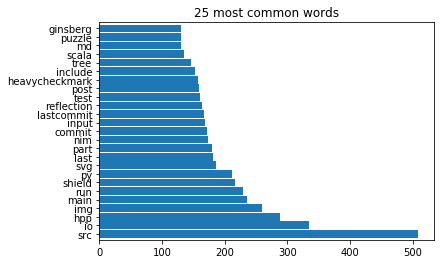

In [27]:
raw_count.sort_values(ascending=False)[0:25].plot.barh(width=.9)
plt.title('25 most common words')

### How does this look for popular languages?

#### Python

In [28]:
python_text = " ".join(df[df.language == "Python"].prepped)
python_words = python_text.split()

In [29]:
python_count = pd.Series(python_words).value_counts()
python_count.head(15)

img           179
io            173
shield        170
svg           170
commit        167
last          167
lastcommit    166
py            134
part           44
python         38
hand           35
model          33
run            32
tensorflow     29
input          29
dtype: int64

Text(0.5, 1.0, 'Python 10 most common words')

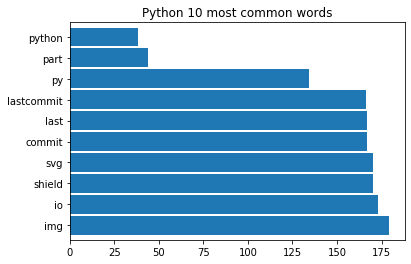

In [30]:
python_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Python 10 most common words')

#### Haskell

In [31]:
haskell_text = " ".join(df[df.language == "Haskell"].prepped)
haskell_words = haskell_text.split()

In [32]:
haskell_count = pd.Series(haskell_words).value_counts()
haskell_count.head(15)

reflection         164
db                  96
dr                  91
challenge           89
src                 89
dh                  64
dg                  64
h                   63
benchmark           52
dc                  50
mdday               49
mddaybenchmarks     48
b                   44
haskell             42
test                40
dtype: int64

Text(0.5, 1.0, 'Haskell 10 most common words')

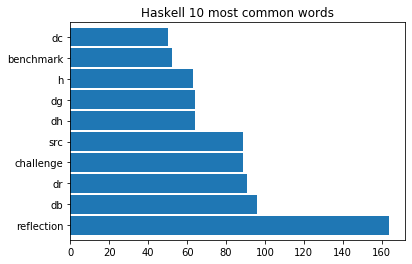

In [33]:
haskell_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Haskell 10 most common words')

#### JavaScript

In [34]:
javascript_text = " ".join(df[df.language == "JavaScript"].prepped)
javascript_words = javascript_text.split()

In [35]:
javascript_count = pd.Series(javascript_words).value_counts()
javascript_count.head(15)

star               46
run                40
puzzle             38
j                  38
test               32
index              32
year               29
npm                27
post               26
net                26
part               26
adventofcodeday    25
tree               21
completion         18
io                 18
dtype: int64

Text(0.5, 1.0, 'JavaScript 10 most common words')

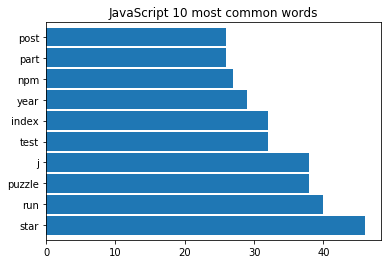

In [36]:
javascript_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('JavaScript 10 most common words')

#### Java

In [37]:
java_text = " ".join(df[df.language == "Java"].prepped)
java_words = java_text.split()

In [38]:
java_count = pd.Series(java_words).value_counts()
java_count.head(15)

problem      33
tree         26
statement    25
java         15
language     14
run          11
badge         9
io            9
shield        9
img           9
input         8
script        6
file          6
scala         6
completed     6
dtype: int64

Text(0.5, 1.0, 'Java 10 most common words')

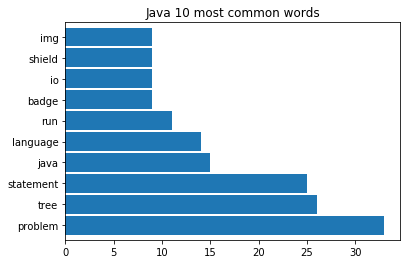

In [39]:
java_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Java 10 most common words')

### Does the length of the README vary by programming language?

# Modeling

In [40]:
tf_df = pd.DataFrame({'raw_count': raw_count})
tf_df = tf_df.assign(term_frequency = lambda df: df.raw_count / df.raw_count.sum())
tf_df.raw_count.max()
tf_df.head()

,raw_count,term_frequency
src,509,0.020205
io,335,0.013298
hpp,288,0.011432
img,259,0.010281
main,236,0.009368


In [41]:
def idf(word):
    n_occurrences = sum([1 for doc in df.prepped if word in doc])
    n_docs = len(df.prepped)
    idf = np.log(n_docs/n_occurrences)
    return idf

In [42]:
idf('python')

1.8035939268750578

In [43]:
idf('shield')

2.3632097148104805

In [44]:
idf('model')

4.037186148382152

In [45]:
unique_words = pd.Series(' '.join(df.prepped).split()).unique()
len(unique_words)

4330

In [46]:
word_df = pd.DataFrame(dict(word = unique_words))
word_df = word_df.assign(idf = lambda df: df.word.apply(idf))
word_df = word_df.set_index('word').sort_values(by='idf', ascending = False)
word_df.head(100)

,idf
word,
sorted,5.135798
succeed,5.135798
bypass,5.135798
getinput,5.135798
yearday,5.135798
emacs,5.135798
knew,5.135798
attempted,5.135798
toolchain,5.135798


In [47]:
df.language.value_counts()

Python         29
Haskell        26
JavaScript     19
Rust           11
Clojure         9
Java            8
Ruby            7
C++             6
Kotlin          6
Go              5
Elixir          5
Scala           5
OCaml           4
C#              4
C               3
Pony            2
HTML            2
Elm             2
APL             1
TypeScript      1
Perl            1
Eiffel          1
PHP             1
F#              1
Shell           1
TSQL            1
Racket          1
Mathematica     1
Haxe            1
Swift           1
Nim             1
Coq             1
Crystal         1
Reason          1
PureScript      1
Name: language, dtype: int64

Make Other Label for non top 5 languages

In [48]:
df['language'] = df['language'].replace({'Ruby':'Other', 'Kotlin':'Other', 'C++':'Other','Go':'Other', 'Elixir':'Other', 'Scala':'Other', 'C#':'Other', 'OCaml':'Other','C':'Other', 'Elm':'Other', 'Pony':'Other', 'HTML':'Other', 'Perl':'Other','APL':'Other', 'Haxe':'Other', 'Racket':'Other', 'PureScript':'Other', 'Coq':'Other','F#':'Other', 'PHP':'Other', 'TSQL':'Other', 'Crystal':'Other', 'Nim':'Other', 'Shell':'Other', 'Eiffel':'Other', 'Mathematica':'Other', 'Swift':'Other', 'Reason':'Other', 'TypeScript':'Other'})

In [49]:
df.language.value_counts()

Other         68
Python        29
Haskell       26
JavaScript    19
Rust          11
Clojure        9
Java           8
Name: language, dtype: int64

In [50]:
#df = df[df['language'].isin(['Python', 'Haskell','JavaScript'])]

In [51]:
df.prepped.value_counts()

## Split

In [52]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.prepped)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

## Model 1: Logistic Regression

In [115]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

### Train Evaluation

In [116]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 61.03%
---
Confusion Matrix
actual      Clojure  Haskell  Java  JavaScript  Other  Python  Rust
predicted                                                          
Haskell           0       13     0           0      0       0     0
JavaScript        0        0     0           5      0       0     0
Other             7        8     7          10     54      12     9
Python            0        0     0           0      0      11     0
---
              precision    recall  f1-score   support

     Clojure       0.00      0.00      0.00         7
     Haskell       1.00      0.62      0.76        21
        Java       0.00      0.00      0.00         7
  JavaScript       1.00      0.33      0.50        15
       Other       0.50      1.00      0.67        54
      Python       1.00      0.48      0.65        23
        Rust       0.00      0.00      0.00         9

    accuracy                           0.61       136
   macro avg       0.50      0.35      0.37       136
weighted

### Test Evaluation

In [117]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 44.12%
---
Confusion Matrix
actual     Clojure  Haskell  Java  JavaScript  Other  Python  Rust
predicted                                                         
Haskell          0        1     0           0      0       0     0
Other            2        4     1           4     14       6     2
---
              precision    recall  f1-score   support

     Clojure       0.00      0.00      0.00         2
     Haskell       1.00      0.20      0.33         5
        Java       0.00      0.00      0.00         1
  JavaScript       0.00      0.00      0.00         4
       Other       0.42      1.00      0.60        14
      Python       0.00      0.00      0.00         6
        Rust       0.00      0.00      0.00         2

    accuracy                           0.44        34
   macro avg       0.20      0.17      0.13        34
weighted avg       0.32      0.44      0.29        34



## Model 2: Decision Tree (Max Depth 7)

In [118]:
# Create
tree = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=123)
# Fit
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [119]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = tree.predict(X_train)
test['predicted'] = tree.predict(X_test)

### Train Evaluation

In [120]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 69.85%
---
Confusion Matrix
actual      Clojure  Haskell  Java  JavaScript  Other  Python  Rust
predicted                                                          
Clojure           4        0     0           0      0       0     0
Haskell           0        8     0           0      0       0     0
Java              0        0     6           0      0       0     0
JavaScript        0        0     0           9      0       0     0
Other             3       13     1           6     52      13     3
Python            0        0     0           0      2      10     0
Rust              0        0     0           0      0       0     6
---
              precision    recall  f1-score   support

     Clojure       1.00      0.57      0.73         7
     Haskell       1.00      0.38      0.55        21
        Java       1.00      0.86      0.92         7
  JavaScript       1.00      0.60      0.75        15
       Other       0.57      0.96      0.72        54
      Python       0.

### Test Evaluation

In [121]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 67.65%
---
Confusion Matrix
actual      Clojure  Haskell  Java  JavaScript  Other  Python  Rust
predicted                                                          
Clojure           2        0     0           0      0       0     0
Haskell           0        2     0           0      0       0     0
JavaScript        0        0     0           1      0       0     0
Other             0        2     1           3     14       4     0
Python            0        1     0           0      0       2     0
Rust              0        0     0           0      0       0     2
---
              precision    recall  f1-score   support

     Clojure       1.00      1.00      1.00         2
     Haskell       1.00      0.40      0.57         5
        Java       0.00      0.00      0.00         1
  JavaScript       1.00      0.25      0.40         4
       Other       0.58      1.00      0.74        14
      Python       0.67      0.33      0.44         6
        Rust       1.00      1.00  

## Model 3: Random Forest

In [122]:
# Create
rf = RandomForestClassifier(min_samples_leaf=3, max_depth=9, random_state=123)
# Fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [123]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
# Predict
train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

### Train Evaluation

In [124]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 54.41%
---
Confusion Matrix
actual      Clojure  Haskell  Java  JavaScript  Other  Python  Rust
predicted                                                          
Haskell           0        3     0           0      0       0     0
JavaScript        0        0     0           6      0       0     0
Other             7       18     6           9     53      14     6
Python            0        0     1           0      1       9     0
Rust              0        0     0           0      0       0     3
---
              precision    recall  f1-score   support

     Clojure       0.00      0.00      0.00         7
     Haskell       1.00      0.14      0.25        21
        Java       0.00      0.00      0.00         7
  JavaScript       1.00      0.40      0.57        15
       Other       0.47      0.98      0.63        54
      Python       0.82      0.39      0.53        23
        Rust       1.00      0.33      0.50         9

    accuracy                           0.54     

### Test Evaluation

In [125]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 44.12%
---
Confusion Matrix
actual      Clojure  Haskell  Java  JavaScript  Other  Python  Rust
predicted                                                          
JavaScript        0        0     0           1      0       0     0
Other             2        5     1           3     14       6     2
---
              precision    recall  f1-score   support

     Clojure       0.00      0.00      0.00         2
     Haskell       0.00      0.00      0.00         5
        Java       0.00      0.00      0.00         1
  JavaScript       1.00      0.25      0.40         4
       Other       0.42      1.00      0.60        14
      Python       0.00      0.00      0.00         6
        Rust       0.00      0.00      0.00         2

    accuracy                           0.44        34
   macro avg       0.20      0.18      0.14        34
weighted avg       0.29      0.44      0.29        34

